In [4]:
scripts_path = '../../scripts'
import sys
sys.path.append(scripts_path)
import numpy as np
import matplotlib.pyplot as plt
import signal_processing as sp
import os
os.getcwd()

'/home/drozdovmk/Projects/ZB/zb-classification/RnD/notebooks'

In [7]:
#hdf5 files
from creating_datasets import make_tsfresh_structure_from_directory
path_to_hdf5_directory  = '../../data/hdf5_adaptive/'

data_hdf5_long, label_hdf5 = make_tsfresh_structure_from_directory(path_to_hdf5_directory)
data_hdf5_long = data_hdf5_long.reset_index(drop=True)


In [8]:
label_hdf5[label_hdf5 == 'hit_z']
data_hdf5_long

,id,time,raw,sko_32,mean_256,median_128
0,0,0,0.251928,0.004771,0.247965,0.248962
1,0,1,0.238286,0.004962,0.247951,0.249110
2,0,2,0.248814,0.004815,0.247914,0.249110
3,0,3,0.247628,0.004701,0.247908,0.249110
4,0,4,0.252521,0.004577,0.247981,0.248962
...,...,...,...,...,...,...
2001331,421,1958,0.238503,0.022263,0.260951,0.267380
2001332,421,1959,0.275401,0.021355,0.261157,0.268182
2001333,421,1960,0.246524,0.021872,0.261444,0.267380
2001334,421,1961,0.245455,0.022496,0.261946,0.267112


Text(0.5, 1.0, 'hist')

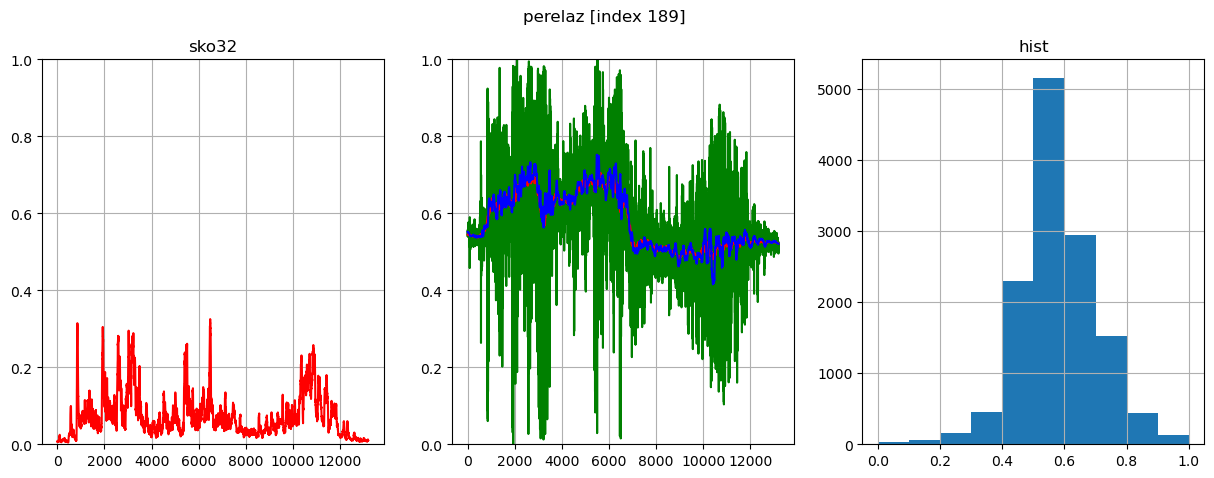

In [8]:
# Визуализация hdf5 объектов
fig, ax = plt.subplots(1,3, figsize = (15, 5))
idx = np.random.choice(label_hdf5.index)

fig.suptitle(label_hdf5[idx] + ' [index {}]'.format(idx))
ax[0].plot(data_hdf5_long[data_hdf5_long['id']== idx]['sko_32'].reset_index(), color = 'red')
ax[0].set_ylim([0, 1])
ax[0].set_title('sko32')
ax[0].grid()
ax[1].plot(data_hdf5_long[data_hdf5_long['id']== idx]['raw'].reset_index(),
           color = 'green', label = 'raw')
ax[1].plot(data_hdf5_long[data_hdf5_long['id']== idx]['mean_256'].reset_index(),
           color = 'red', label = 'mean_256')
ax[1].plot(data_hdf5_long[data_hdf5_long['id']== idx]['median_128'].reset_index(drop=True),
           color = 'blue', label = 'median_128')

ax[1].set_ylim([0, 1])
ax[1].grid()

ax[2].hist(data_hdf5_long[data_hdf5_long['id']== idx]['raw'])
ax[2].grid()
ax[2].set_title('hist')


Text(0, 0.5, 'Амплитуда, отн.ед.')

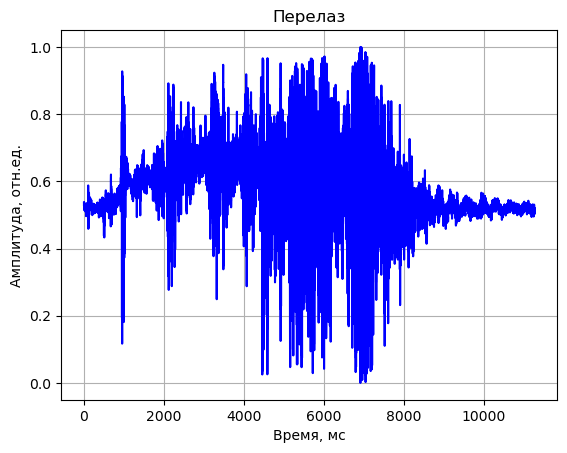

In [9]:
# Визуализация hdf5 объектов

idx = np.random.choice(label_hdf5.index)
idx = 191
plt.plot(data_hdf5_long[data_hdf5_long['id']== idx]['raw'].reset_index(drop = True), color = 'blue', label = 'сырой сигнал')
plt.title('Перелаз')
plt.grid()
plt.xlabel('Время, мс')
plt.ylabel('Амплитуда, отн.ед.')

In [10]:
# Tsfresh
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

def get_features():
        
    sett_answ = {
    "sko_32": {"median": None,
               "length": None,
               "skewness": None,
               "standard_deviation": None,
               },
    "mean_256": {"standard_deviation": None,
                 "kurtosis": None,
                },
    "raw" : {"skewness": None,
             "kurtosis": None,
             "standard_deviation":None
            },
    "median_128": {"standard_deviation": None,
                   }
    }
    
    return sett_answ

In [11]:


data_tsfresh = data_hdf5_long
data_tsfresh = extract_features(data_tsfresh,
                                column_id='id',
                                impute_function=impute,
                                column_sort='time',
                                kind_to_fc_parameters = get_features(),
                                n_jobs = 3)

data_tsfresh['sko_32__log_median'] = np.log(data_tsfresh['sko_32__median'])
data_tsfresh['sko_32__log_length'] = np.log(data_tsfresh['sko_32__length'])
data_tsfresh['median_128__log_standard_deviation'] = np.log(data_tsfresh['median_128__standard_deviation'])



data_tsfresh.drop(['median_128__standard_deviation'],axis = 1, inplace=True)
data_tsfresh.drop(['sko_32__length'],axis = 1, inplace=True)
data_tsfresh.drop(['sko_32__median'],axis = 1, inplace=True)

# data_tsfresh.drop(['raw__kurtosis'],axis = 1, inplace=True)
# data_tsfresh.drop(['raw__standard_deviation'],axis = 1, inplace=True)
data_tsfresh.drop(['mean_256__standard_deviation'],axis = 1, inplace=True)
data_tsfresh.drop(['sko_32__skewness'],axis = 1, inplace=True)
# data_tsfresh.drop(['sko_32__standard_deviation'],axis = 1, inplace=True)

data_tsfresh['label'] = label_hdf5

Feature Extraction: 100%|██████████| 15/15 [00:00<00:00, 52.36it/s]


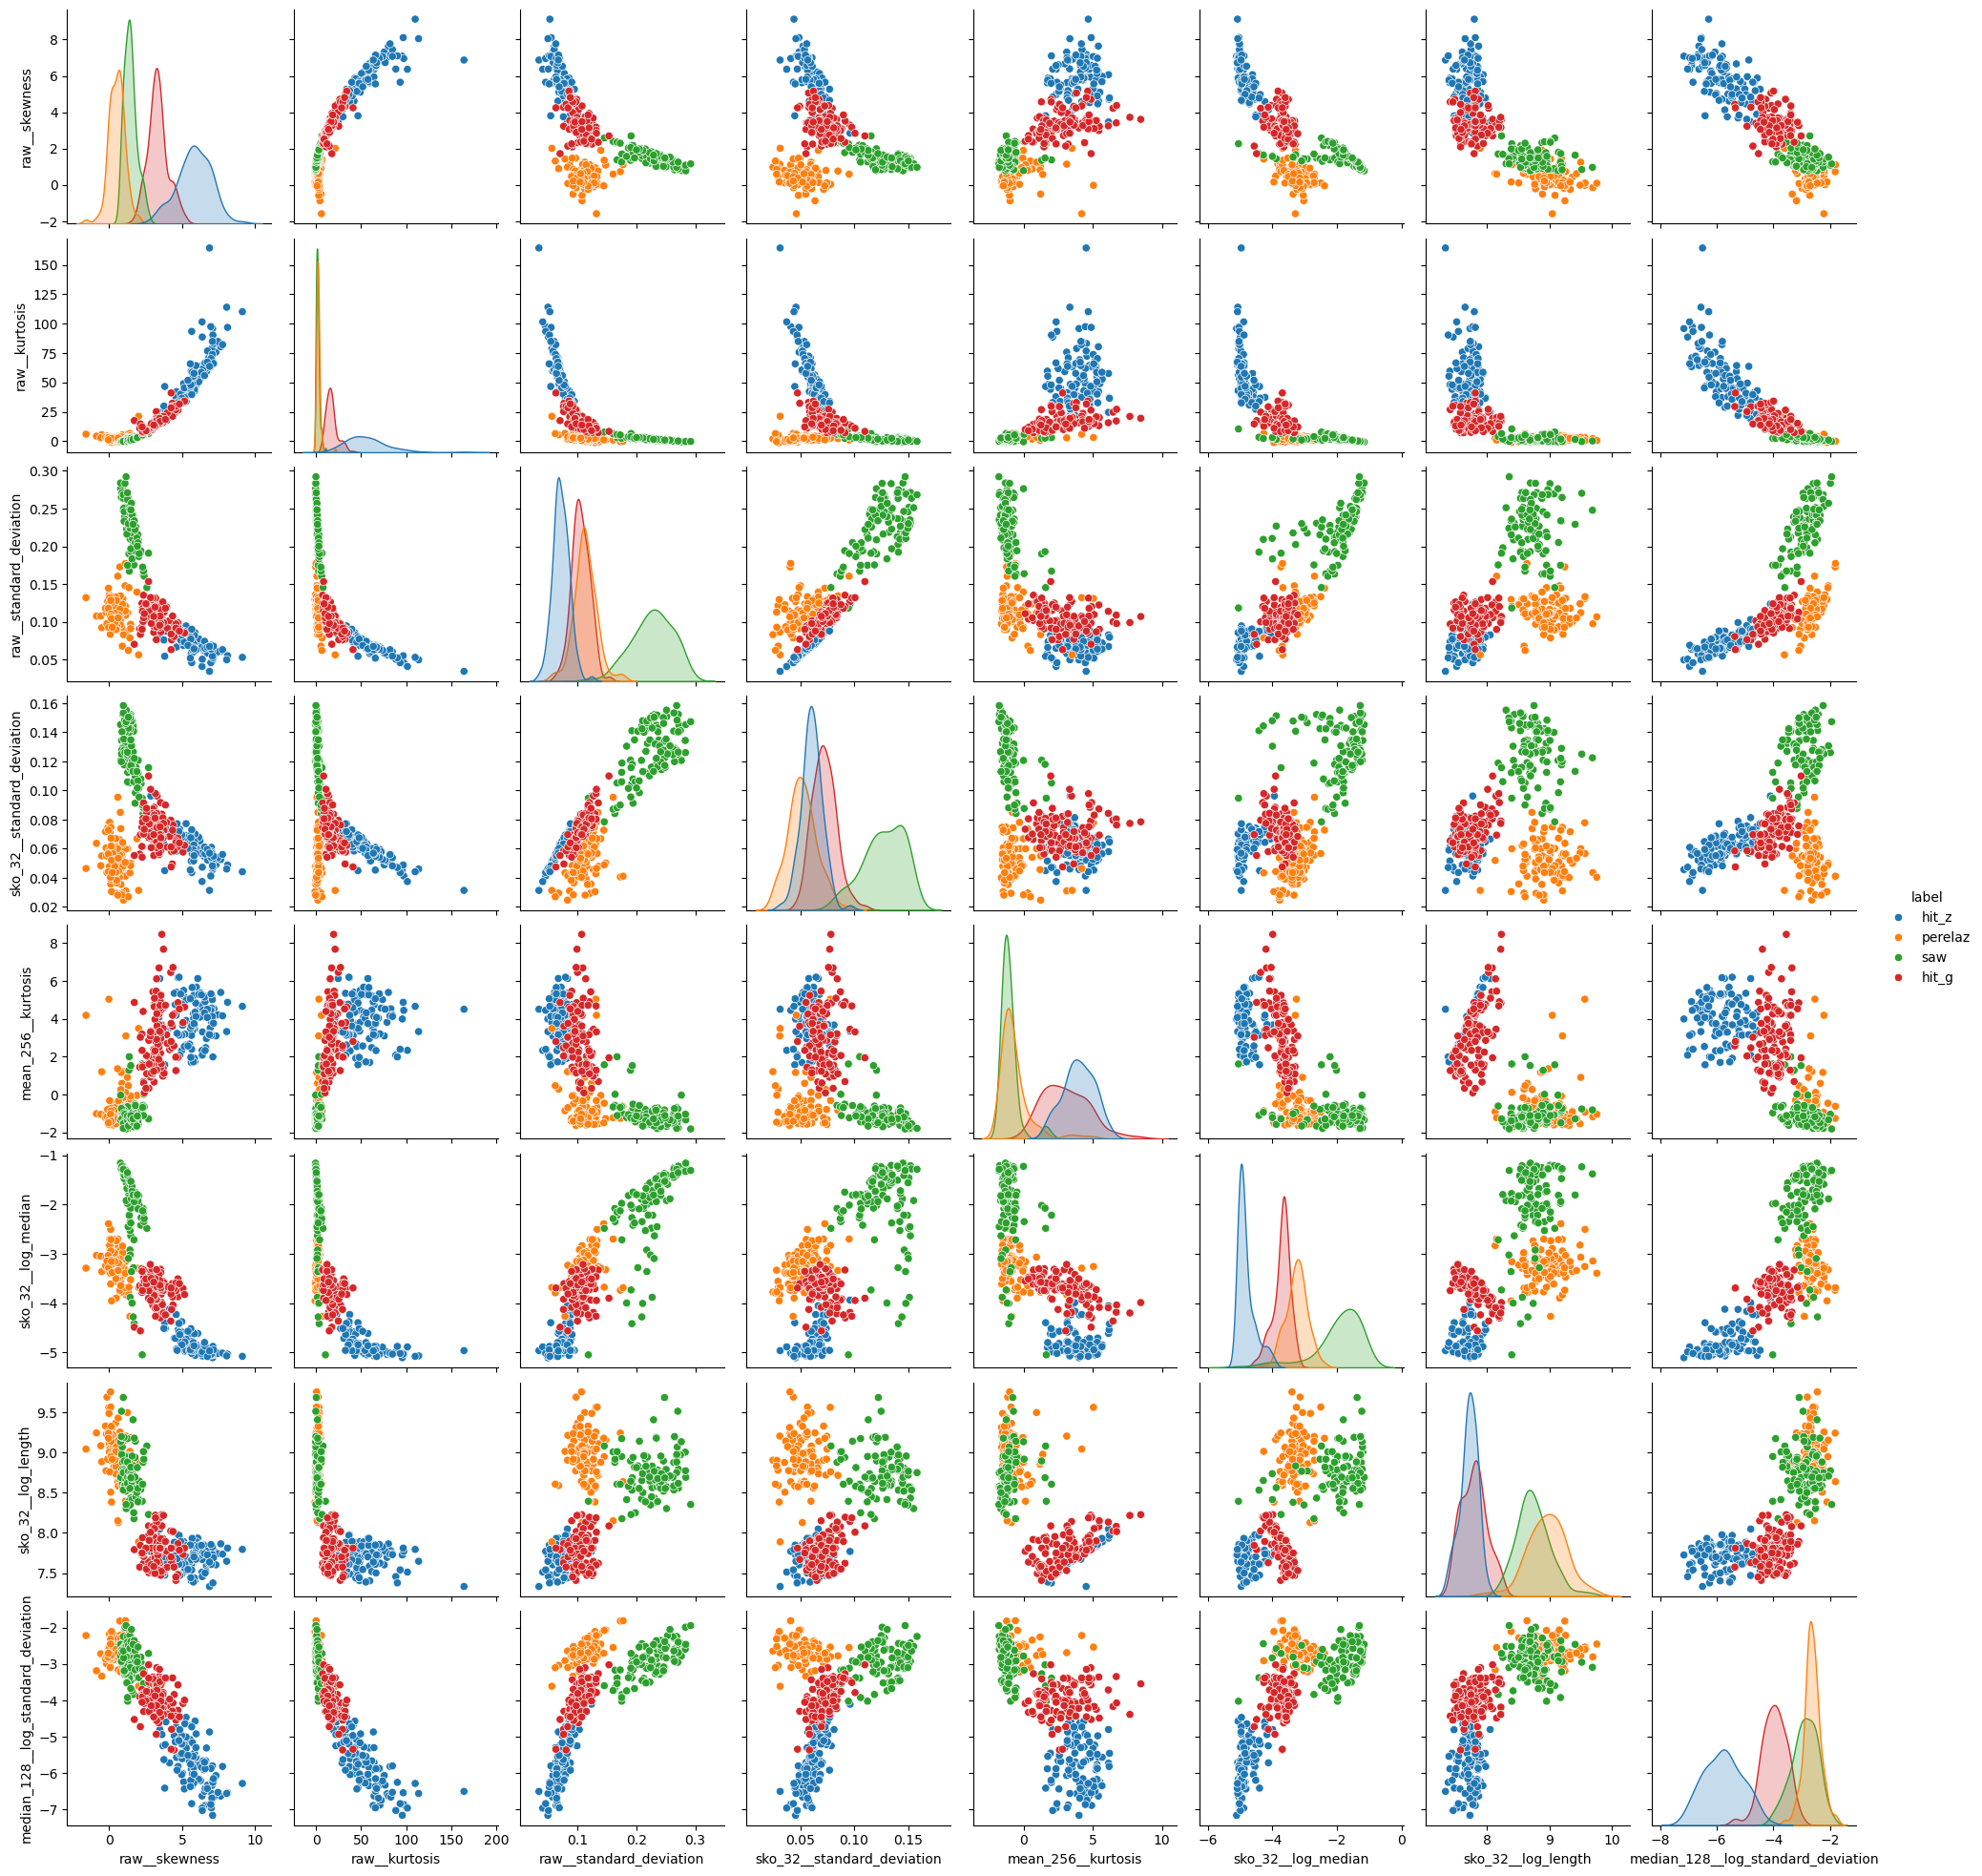

In [12]:
import seaborn as sns

sns.pairplot(data=data_tsfresh, hue = 'label')

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

X = data_tsfresh.iloc[:, :-1]
y = data_tsfresh.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=True, stratify=y)

In [14]:
from sklearn.metrics import confusion_matrix
param_grid = {
    'penalty': ['elasticnet'],
    'l1_ratio': [0.15, 0.5, 0.85],
    'tol': [1e-2, 1e-3, 1e-4, 1e-5],
    'C': [0.01, 0.1, 1],
    'solver': ['saga'],
    'max_iter': [100,200,300,400, 500],
    'multi_class': ['multinomial', 'ovr']   
}

logreg = LogisticRegression(n_jobs = -1)
grid_search_logreg = GridSearchCV(estimator=logreg, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1)
grid_search_logreg.fit(X_train, y_train)


best_params = grid_search_logreg.best_params_
print("Лучшие параметры:", best_params)

best_model_lr = grid_search_logreg.best_estimator_
y_pred = best_model_lr.predict(X_test)

# Выводим результаты
print("Отчет по классификации:\n", classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

/home/drozdovmk/anaconda3/envs/ZB/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/drozdovmk/anaconda3/envs/ZB/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/drozdovmk/anaconda3/envs/ZB/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/drozdovmk/anaconda3/envs/ZB/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/drozdovmk/anaconda3/envs/ZB/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/droz

Лучшие параметры: {'C': 1, 'l1_ratio': 0.15, 'max_iter': 500, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga', 'tol': 0.0001}
Отчет по классификации:
               precision    recall  f1-score   support

       hit_g       0.91      0.91      0.91        11
       hit_z       0.91      0.91      0.91        11
     perelaz       1.00      1.00      1.00        10
         saw       1.00      1.00      1.00        11

    accuracy                           0.95        43
   macro avg       0.95      0.95      0.95        43
weighted avg       0.95      0.95      0.95        43



/home/drozdovmk/anaconda3/envs/ZB/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


array([[10,  1,  0,  0],
       [ 1, 10,  0,  0],
       [ 0,  0, 10,  0],
       [ 0,  0,  0, 11]])

In [15]:
print(best_model_lr.classes_)
a= best_model_lr.predict_proba(X_test).round(2)
b= y_test.reset_index(drop = True).to_numpy().reshape(1,-1).T
np.concatenate((a,b), axis = 1)

['hit_g' 'hit_z' 'perelaz' 'saw']


array([[0.01, 0.99, 0.0, 0.0, 'hit_z'],
       [0.0, 0.0, 0.74, 0.25, 'perelaz'],
       [0.16, 0.84, 0.0, 0.0, 'hit_z'],
       [0.0, 0.0, 0.81, 0.19, 'perelaz'],
       [0.01, 0.0, 0.07, 0.92, 'saw'],
       [0.0, 1.0, 0.0, 0.0, 'hit_z'],
       [0.0, 0.0, 0.05, 0.95, 'saw'],
       [0.07, 0.93, 0.0, 0.0, 'hit_z'],
       [0.0, 0.0, 0.87, 0.13, 'perelaz'],
       [0.0, 1.0, 0.0, 0.0, 'hit_z'],
       [0.02, 0.0, 0.76, 0.21, 'perelaz'],
       [0.03, 0.97, 0.0, 0.0, 'hit_z'],
       [0.94, 0.06, 0.0, 0.0, 'hit_g'],
       [0.0, 0.0, 0.93, 0.06, 'perelaz'],
       [0.0, 0.0, 0.95, 0.05, 'perelaz'],
       [0.0, 0.0, 0.83, 0.17, 'perelaz'],
       [0.01, 0.0, 0.04, 0.96, 'saw'],
       [0.01, 0.0, 0.03, 0.96, 'saw'],
       [0.01, 0.0, 0.06, 0.93, 'saw'],
       [0.33, 0.67, 0.0, 0.0, 'hit_z'],
       [0.05, 0.0, 0.25, 0.7, 'saw'],
       [0.84, 0.01, 0.04, 0.11, 'hit_g'],
       [0.79, 0.21, 0.0, 0.0, 'hit_z'],
       [0.58, 0.01, 0.21, 0.2, 'hit_g'],
       [0.0, 0.0, 0.77, 0.23, 'per

In [14]:
coefficients = best_model_lr.coef_
intercept = best_model_lr.intercept_

# Визуализируем коэффициенты
import pandas as pd
coef_df = pd.DataFrame(coefficients, columns=X.columns, index=y.unique())
print("Коэффициенты логистической регрессии:")
print(coef_df)
print("Смещения (интерсепты):", intercept)

Коэффициенты логистической регрессии:
         raw__skewness  raw__kurtosis  raw__standard_deviation  \
hit_z         0.373129       0.187850                 0.000000   
perelaz      -0.192422       0.452730                -0.006159   
saw          -0.901930      -0.259127                -0.084503   
hit_g         0.721223      -0.381450                 0.100119   

         sko_32__standard_deviation  mean_256__kurtosis  sko_32__log_median  \
hit_z                      0.000000            0.186857            0.039082   
perelaz                    0.000000            0.119190            0.049011   
saw                       -0.061194            0.044678           -0.756955   
hit_g                      0.066823           -0.355632            0.663824   

         sko_32__log_length  median_128__log_standard_deviation  
hit_z             -0.086415                            0.037407  
perelaz           -0.731672                            0.005785  
saw                0.400583          

In [31]:
# import os
# os.listdir('../')
# import joblib
# joblib.dump(best_model_lr, '../classifier_v2/logistic_regression.pkl')

['obj_cases',
 'classifier_v2_rf',
 'pics_features_tsfresh',
 'GUI_saver',
 'demo_app_4sek_version',
 'classifier_v2_lr',
 'saved_models',
 'report_1.odt',
 'data',
 '.python-version',
 'notebooks']

In [15]:
param_grid = {
    'classifier__n_estimators': [100, 150, 250],            # Количество деревьев в лесу
    'classifier__criterion': ['gini', 'entropy'],          # Критерий для оценки качества разбиения
    'classifier__max_depth': [None, 10, 20, 30]            # Максимальная глубина дерева
}

rf = Pipeline([('classifier', RandomForestClassifier())])

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

best_params = grid_search_rf.best_params_
print("Лучшие параметры:", best_params)

# Оцениваем модель на тестовой выборке
best_model_rf = grid_search_rf.best_estimator_
y_pred = best_model_rf.predict(X_test)

# Выводим результаты
print("Отчет по классификации:\n", classification_report(y_test, y_pred))


Лучшие параметры: {'classifier__criterion': 'entropy', 'classifier__max_depth': 30, 'classifier__n_estimators': 250}
Отчет по классификации:
               precision    recall  f1-score   support

       hit_g       1.00      0.91      0.95        11
       hit_z       0.92      1.00      0.96        11
     perelaz       1.00      1.00      1.00        10
         saw       1.00      1.00      1.00        11

    accuracy                           0.98        43
   macro avg       0.98      0.98      0.98        43
weighted avg       0.98      0.98      0.98        43



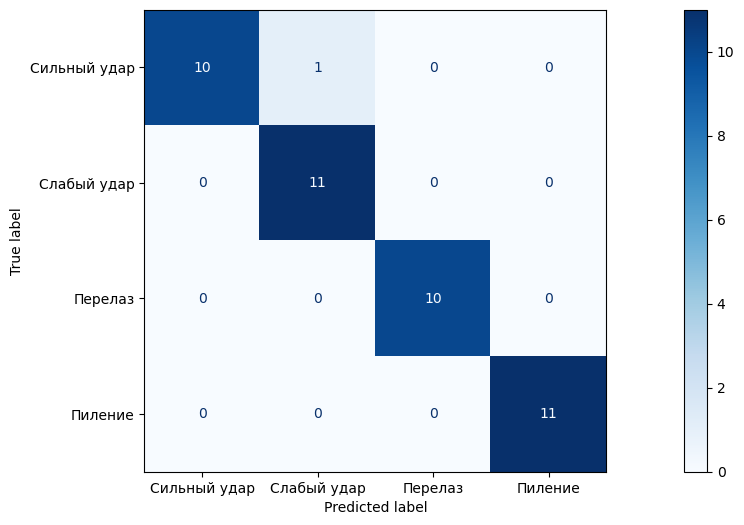

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Сильный удар', 'Слабый удар', 'Перелаз', 'Пиление'])
fig, ax = plt.subplots(figsize = (20,6))
disp.plot(cmap='Blues', ax = ax)

In [177]:
# import os
# os.listdir('../..')
# import joblib
# joblib.dump(best_model_rf, '../../RnD/classifier_v2/random_forest.pkl')

['../../RnD/classifier_v2/random_forest.pkl']

In [26]:
a = np.array(sorted(best_model_rf.feature_names_in_))

In [35]:
best_model_rf.predict_proba(X_test)

array([[0.  , 0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.84, 0.16, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.76, 0.24, 0.  , 0.  ],
       [0.  , 0.  , 0.99, 0.01],
       [0.  , 0.  , 0.83, 0.17],
       [0.  , 0.  , 1.  , 0.  ],
       [0.07, 0.93, 0.  , 0.  ],
       [0.07, 0.93, 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.03, 0.97],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.99, 0.  , 0.01, 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.96, 0.04, 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.96, 0.04],
       [0.  , 0.  , 0.  , 1.  ],
       [0.